In [3]:
!pip install -U matplotlib
!pip install tensorflow-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 79.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.7 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [4]:
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose,Add,Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
import tensorflow_extra as tfa
import os
import random

2025-10-14 20:36:43.442512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760474203.624079      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760474203.688485      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
#preprocessing
BATCH_SIZE = 16
TIME_STEPS = 1000
IM_SHAPE = (64,64,3)
N_HEADS = 8
ATTN_DIM = 256
N_GROUPS = 2
N_RESNETS = 2
LEARNING_RATE = 2e-4

In [12]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/celeba-dataset/img_align_celeba/", label_mode = None, image_size=(IM_SHAPE[0], IM_SHAPE[1]),batch_size=32
)

Found 202599 files.


In [6]:
def preprocess(image):
  return tf.cast(image,tf.float32)/127.5-1.0

In [7]:
def augmentation(image):
  return ...

In [13]:
train_dataset = (
    ds_train
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

for d in train_dataset.take(1):
  print(d.shape)

(16, 64, 64, 3)


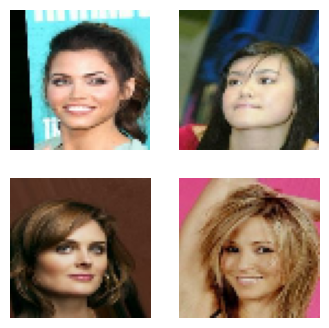

In [14]:
#data visualization
plt.figure(figsize = (4,4))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k=k+1

In [7]:
#dataset prep
def linear_beta_schedule(timestamps):
  beta_start = 0.0001
  beta_end = 0.02
  return tf.linspace(beta_start,beta_end,timestamps)

In [8]:
betas = linear_beta_schedule(TIME_STEPS)
#defining alpha
alphas  = 1-betas
alphas_cumprod = tf.math.cumprod(alphas,axis=0)
alphas_cumprod_prev = tf.concat([tf.ones((1,)),alphas_cumprod[:-1]],axis = 0)
sqrt_recip_alphas = tf.math.sqrt(1.0/alphas)

#calculating for diffusion layer
sqrt_alphas_cumprod = tf.math.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1-alphas_cumprod)

#calculating posterior variance
posterior_variance = betas*(1-alphas_cumprod_prev)/(1-alphas_cumprod)

I0000 00:00:1760474276.905042      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
def extract(a,t,x_shape):
  b, *_ = t.shape
  out = tf.gather(a,t)
  output = tf.reshape(out, (b,*((1,)*(len(x_shape)-1))))
  return output

In [10]:
def q_sample(x_start,t,noise):
  sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod,t,x_start.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod,t,x_start.shape)
  out_sample = sqrt_alphas_cumprod_t*x_start + sqrt_one_minus_alphas_cumprod_t*noise
  return out_sample

In [15]:
x_start = d
t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS,dtype=tf.int32)
print(t)
print(x_start.shape,t.shape,)
sample = q_sample(x_start,t,tf.random.normal(x_start.shape))
print(sample.shape)

tf.Tensor([317 137 527  90  96 959 266 627 503 524 444 343 375 268 244 198], shape=(16,), dtype=int32)
(16, 64, 64, 3) (16,)
(16, 64, 64, 3)


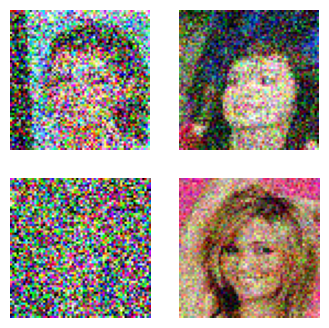

In [16]:
plt.figure(figsize = (4,4))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((sample[i]+1)/2)
  plt.axis("off")
  k = k+1

In [20]:
#Modelling DDPM
class PositionalEmbeddings(tf.keras.layers.Layer):
  def __init__(self,dim):
    super().__init__()
    self.embedding_dim = dim

  def get_timestep_embedding(self,timesteps,embedding_dim: int):
    half_dim = self.embedding_dim // 2
    emb = tf.math.log(10000.)/(half_dim-1)
    emb = tf.exp(tf.range(half_dim, dtype=tf.float32)* -emb)
    emb = tf.cast(timesteps, dtype=tf.float32)[:,None]*emb[None, :]
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:
      emb = tf.pad(emb, [[0, 0], [0, 1]])
    return emb

  def call(self,time):
    return self.get_timestep_embedding(time, self.embedding_dim)

In [21]:
#residual block
def res_block(x,filters,n_groups,temb):
  previous = x
  x = Conv2D(filters, 3, padding="same",)(x) 
  x+= Dense(filters)(tf.keras.activations.swish(temb))[:,None,None,:]
  #using group normalization
  x = tf.keras.activations.swish(tf.keras.layers.GroupNormalization(n_groups, axis=-1)(x))
  x = Conv2D(filters,3,padding="same",)(x)
  residual = Conv2D(filters,1,padding="same",)(previous)
  x = tf.keras.layers.add([x,residual])
  return x

# U-Net Model Architecture
The U-Net is a convolutional neural network architecture designed for image segmentation, but it has been successfully adapted for various image-to-image tasks, including diffusion models. Its name comes from its U-shaped structure, which consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

In diffusion models, the U-Net is used to predict the noise added to an image at a particular time step. The network takes a noisy image and the current time step as input and outputs the predicted noise.

In [22]:
#Unet model
def get_model(im_shape=(64,64,3), n_resnets=2,n_groups=8,attn_dim=32,n_heads=4):
  input1 = Input(shape=im_shape)
  input2 = Input(shape=())
  t_dim = im_shape[0]*16
  x = Conv2D(32,3,padding="same",)(input1)
  temb = PositionalEmbeddings(t_dim)(input2)
  temb = Dense(t_dim)(tf.keras.activations.gelu(Dense(t_dim)(temb)))
  hs = []
  
  # Encoder
  for filters in [32,64,128,256]:
    for _ in range(n_resnets):
      x = res_block(x,filters,n_groups,temb)
      if filters == 64:
        x = tf.keras.layers.GroupNormalization(groups = n_groups,axis = -1)(
            MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
    hs.append(x)  # Save skip connection before downsampling
    if filters != 256:  # Don't downsample after the last encoder block
      x = tf.keras.layers.MaxPooling2D(2,strides=2,padding="same")(x)
      
  #Bottleneck
  x = res_block(x,256,n_groups,temb)
  x = tf.keras.layers.GroupNormalization(groups = n_groups,axis = -1)(
      MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
  x = res_block(x,256,n_groups,temb)
  
  #upward path
  for filters in [256,128,64,32]:
    skip = hs.pop()
    
    # Upsample first (except for the first decoder block where sizes already match)
    if filters != 256:
      x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip])
    
    for _ in range(n_resnets):
      x = res_block(x,filters,n_groups,temb)
      if filters == 64:
        x = tf.keras.layers.GroupNormalization(groups = n_groups,axis = -1)(
            MultiHeadAttention(num_heads=n_heads, key_dim = attn_dim,attention_axes=(1,2))(query=x, value=x))
            
  x = res_block(x,32,n_groups,temb)
  output = Conv2D(3,3,padding="same",)(x)
  model = Model([input1,input2],output,name='unet')
  return model

In [23]:
model = get_model(im_shape=IM_SHAPE,n_resnets=N_RESNETS,n_groups=N_GROUPS,attn_dim = ATTN_DIM,n_heads=N_HEADS,)
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 1024)      │          0 │ input_layer_1[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,049,600 │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gelu (Gelu)         │ (None, 1024)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  1,049,600 │ gelu[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu (Silu)         │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     32,800 │ silu[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 1, 1, 32)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 64, 64,    │         64 │ add[0][0]         │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_1 (Silu)       │ (None, 64, 64,    │          0 │ group_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      9,248 │ silu_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      1,056 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_2 (Silu)       │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_2[0][0],   │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     32,800 │ silu_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,645,667 (71.13 MB)

 Trainable params: 18,645,667 (71.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#Training
OPTIMIZER = Adam(learning_rate= 0.5e-4)

In [21]:
def custom_loss(denoise_model,x_start,t,noise=None):
  h = tf.keras.losses.Huber()
  noise = tf.random.normal(x_start.shape,mean=0,stddev=1)
  x_noisy = q_sample(x_start,t,noise)
  predicted_noise = denoise_model([x_noisy,t])
  # Removed plotting code as it's not compatible with tf.function
  # plt.figure(figsize = (10,10))
  # outs = [x_noisy,noise,predicted_noise]
  # print('predicted------------',predicted_noise)
  # print('actual -------------;',noise)
  # for i in range(3):
  #     ax = plt.subplot(1,3, i+1)
  #     plt.imshow(outs[i][10])
  #     plt.axis("off")
  return h(noise,predicted_noise)

In [22]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS,dtype=tf.int32)
    loss = custom_loss(model,x_batch,t)
  
  partial_derivatives = recorder.gradient(loss,model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives,model.trainable_weights))
  return loss

In [23]:
def learn(EPOCHS):
  for epoch in range(EPOCHS):
    init_time = time.time()
    losses = []
    for step,x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
      losses.append(loss)
      if step%500==0:
        print(step)

    print(str(epoch+1)+"/"+str(EPOCHS)+": Training Loss = ", sum(losses)/len(losses))
    print("Time taken:"+str(time.time()-init_time)+'s')
    model.save(f'/kaggle/working/unet_epoch_{epoch+1}.keras')
  print("Training COmplete")

In [ ]:
learn(10)

E0000 00:00:1760418528.380998      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/huber_loss/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1760418531.620971     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
1/10: Training Loss =  tf.Tensor(0.036737125, shape=(), dtype=float32)
Time taken:6982.788043022156s
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
2/10: Training Loss =  tf.Tensor(0.019827694, shape=(), dtype=float32)
Time taken:6936.981035709381s
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
3/10: Training Loss =  tf.Tensor(0.017649379, shape=(), dtype=float32)
Time taken:6936.139407873154s
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
4/10: Training Loss =  tf.Tensor(0.015635157, shape=(), dtype=float32)
Time taken:6935.978028059006s
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
70

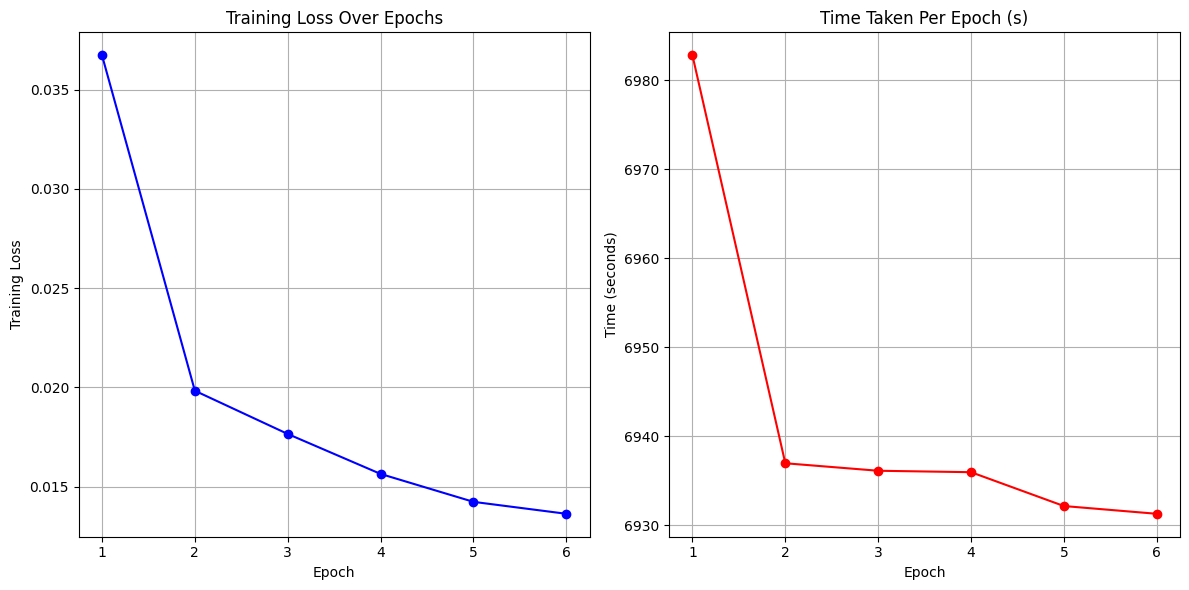

In [1]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.array([1, 2, 3, 4, 5, 6])
loss_values = np.array([0.036737125, 0.019827694, 0.017649379, 0.015635157, 0.014227927, 0.013625938])
time_taken = np.array([6982.788043022156, 6936.981035709381, 6936.139407873154, 6935.978028059006, 6932.178110599518, 6931.307115077972])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, marker='o', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, time_taken, marker='o', color='red')
plt.title('Time Taken Per Epoch (s)')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

Loading model...


I0000 00:00:1760538053.559290      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model loaded successfully!
Noise schedule defined

Starting generation...


I0000 00:00:1760538057.470622      37 cuda_dnn.cc:529] Loaded cuDNN version 90300


Timestep: 900/1000
Timestep: 800/1000
Timestep: 700/1000
Timestep: 600/1000
Timestep: 500/1000
Timestep: 400/1000
Timestep: 300/1000
Timestep: 200/1000
Timestep: 100/1000
Timestep: 0/1000
Generation complete!


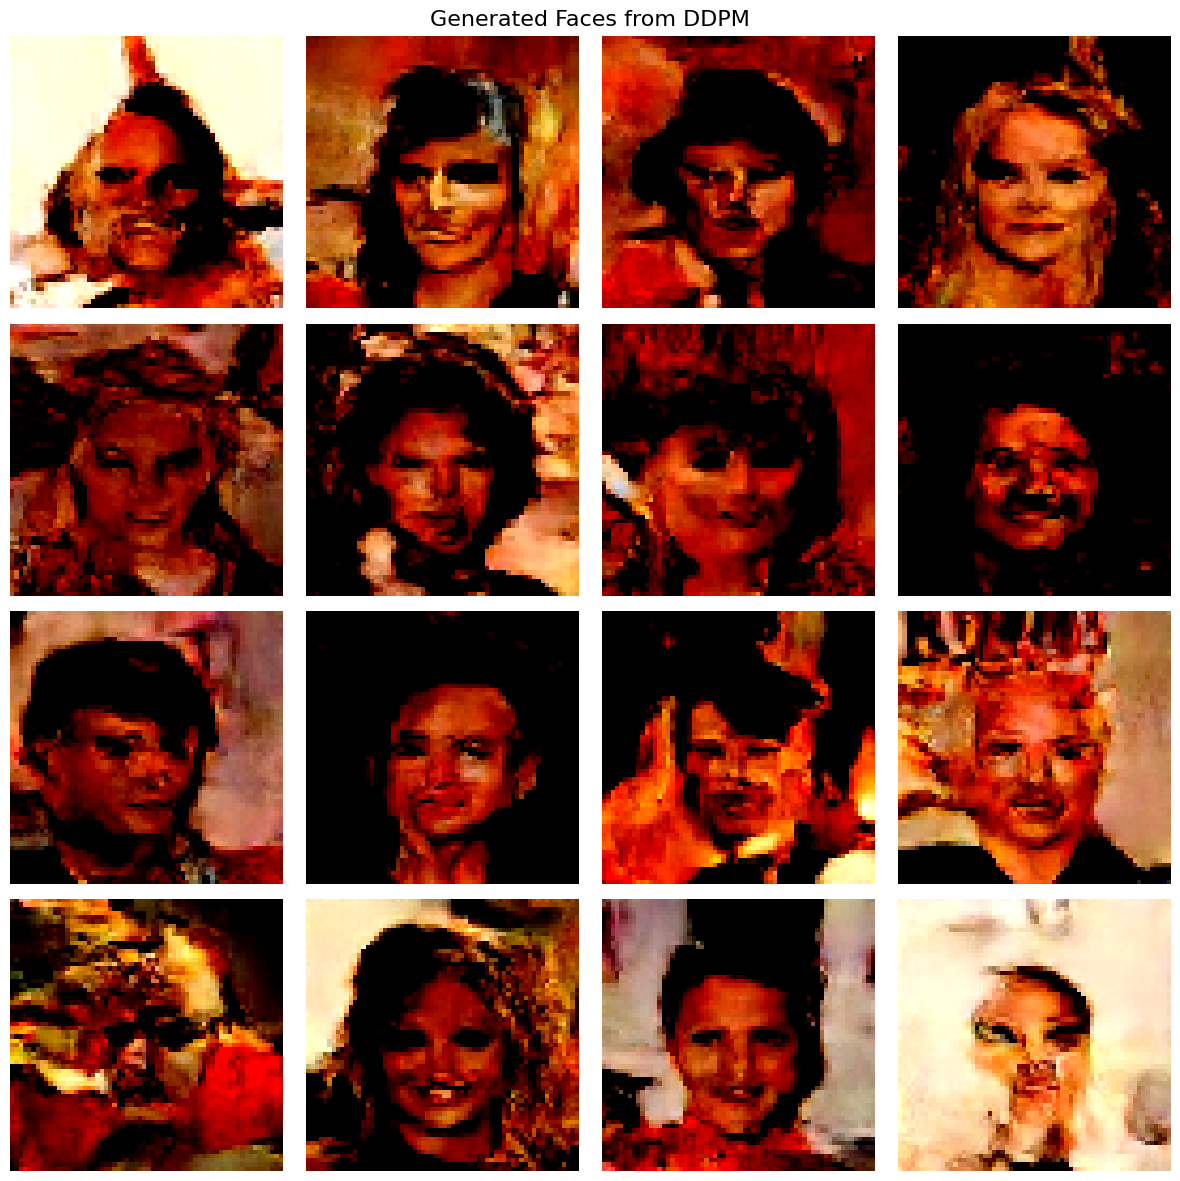

Successfully generated 16 images!


In [2]:
#sampling and testing
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class PositionalEmbeddings(tf.keras.layers.Layer):
    def __init__(self, dim, trainable=True, dtype=None, **kwargs):
        super().__init__(trainable=trainable, dtype=dtype, **kwargs)
        self.dim = dim
    
    def call(self, timesteps):
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = tf.exp(tf.range(half_dim, dtype=tf.float32) * -embeddings)
        embeddings = tf.cast(timesteps, dtype=tf.float32)[:, None] * embeddings[None, :]
        embeddings = tf.concat([tf.sin(embeddings), tf.cos(embeddings)], axis=-1)
        return embeddings
    
    def get_config(self):
        config = super().get_config()
        config.update({"dim": self.dim})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

def res_block(x, filters, n_groups, temb):

    h = tf.keras.layers.GroupNormalization(groups=n_groups, axis=-1)(x)
    h = tf.keras.activations.swish(h)
    h = tf.keras.layers.Conv2D(filters, 3, padding='same')(h)
    
    temb_proj = tf.keras.layers.Dense(filters)(tf.keras.activations.swish(temb))
    temb_proj = temb_proj[:, None, None, :]
    h = h + temb_proj
    
    h = tf.keras.layers.GroupNormalization(groups=n_groups, axis=-1)(h)
    h = tf.keras.activations.swish(h)
    h = tf.keras.layers.Conv2D(filters, 3, padding='same')(h)
    
    if x.shape[-1] != filters:
        x = tf.keras.layers.Conv2D(filters, 1)(x)
    
    return x + h

def get_model(im_shape=(64,64,3), n_resnets=2, n_groups=8, attn_dim=32, n_heads=4):
    from tensorflow.keras.layers import Input, Conv2D, Dense, MultiHeadAttention
    from tensorflow.keras import Model
    
    input1 = Input(shape=im_shape)
    input2 = Input(shape=())
    t_dim = im_shape[0]*16
    x = Conv2D(32, 3, padding="same")(input1)
    temb = PositionalEmbeddings(t_dim)(input2)
    temb = Dense(t_dim)(tf.keras.activations.gelu(Dense(t_dim)(temb)))
    hs = []
    
    # Encoder
    for filters in [32,64,128,256]:
        for _ in range(n_resnets):
            x = res_block(x, filters, n_groups, temb)
            if filters == 64:
                x = tf.keras.layers.GroupNormalization(groups=n_groups, axis=-1)(
                    MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2))(query=x, value=x))
        hs.append(x)
        if filters != 256:
            x = tf.keras.layers.MaxPooling2D(2, strides=2, padding="same")(x)
    
    x = res_block(x, 256, n_groups, temb)
    x = tf.keras.layers.GroupNormalization(groups=n_groups, axis=-1)(
        MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2))(query=x, value=x))
    x = res_block(x, 256, n_groups, temb)
    
    # Upward path
    for filters in [256,128,64,32]:
        skip = hs.pop()
        if filters != 256:
            x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, skip])
        
        for _ in range(n_resnets):
            x = res_block(x, filters, n_groups, temb)
            if filters == 64:
                x = tf.keras.layers.GroupNormalization(groups=n_groups, axis=-1)(
                    MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2))(query=x, value=x))
    
    x = res_block(x, 32, n_groups, temb)
    output = Conv2D(3, 3, padding="same")(x)
    model = Model([input1, input2], output, name='unet')
    return model

TIME_STEPS = 1000
IM_SHAPE = (64, 64, 3)
N_HEADS = 8
ATTN_DIM = 256
N_GROUPS = 2
N_RESNETS = 2

print("Loading model...")
try:
    model = tf.keras.models.load_model(
        '/kaggle/input/ddpm_unet/keras/default/1/unet_epoch_5.keras',
        custom_objects={'PositionalEmbeddings': PositionalEmbeddings},
        compile=False
    )
    print("Model loaded successfully!")
except Exception as e:
    print(f"Direct load failed: {e}")
    print("\nTrying alternative method: recreate + load weights...")
    
    model = get_model(im_shape=IM_SHAPE, n_resnets=N_RESNETS, n_groups=N_GROUPS, 
                      attn_dim=ATTN_DIM, n_heads=N_HEADS)
    
    dummy_img = tf.random.normal((1, 64, 64, 3))
    dummy_t = tf.constant([0])
    _ = model([dummy_img, dummy_t], training=False)
    
    try:
        loaded = tf.keras.models.load_model(
            '/kaggle/input/ddpm_unet/keras/default/1/unet_epoch_5.keras',
            custom_objects={'PositionalEmbeddings': PositionalEmbeddings},
            compile=False
        )
        model.set_weights(loaded.get_weights())
        del loaded
        print("Weights loaded successfully!")
    except Exception as e2:
        print(f"Weight loading also failed: {e2}")
        raise

betas = tf.linspace(1e-4, 0.02, TIME_STEPS)
alphas = 1 - betas
alphas_cumprod = tf.math.cumprod(alphas)
sqrt_one_minus_alphas_cumprod = tf.sqrt(1 - alphas_cumprod)
sqrt_recip_alphas = tf.sqrt(1.0 / alphas)

alphas_cumprod_prev = tf.concat([tf.ones(1), alphas_cumprod[:-1]], axis=0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

print("Noise schedule defined")

def extract(a, t, x_shape):
    batch_size = tf.shape(t)[0]
    out = tf.gather(a, t)
    return tf.reshape(out, [batch_size, 1, 1, 1])

def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    predicted_noise = model([x, t], training=False)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = tf.random.normal(x.shape)
        return model_mean + tf.sqrt(posterior_variance_t) * noise

print("\nStarting generation...")
imgs = []
num_samples = 16

img = tf.random.normal((num_samples, IM_SHAPE[0], IM_SHAPE[1], IM_SHAPE[2]))

for i in reversed(range(0, TIME_STEPS)):
    if i % 100 == 0:
        print(f"Timestep: {i}/{TIME_STEPS}")
    
    t = tf.fill((num_samples,), i)
    img = p_sample(model, img, t, i)
    
    if i % 200 == 0 or i == 0:
        imgs.append(img.numpy())

print("Generation complete!")

# VISUALIZE
final_images = np.clip(imgs[-1], 0, 1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(final_images):
        ax.imshow(final_images[i])
        ax.axis('off')

plt.suptitle('Generated Faces from DDPM', fontsize=16)
plt.tight_layout()
plt.savefig('generated_faces.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Successfully generated {len(final_images)} images!")

In [3]:
str("pr")

'pr'


METHOD 1: DDIM Sampling (FAST)
Generating 16 images with DDIM (50 steps)...
Step 50/50 (t=0)))
 DDIM generation complete!


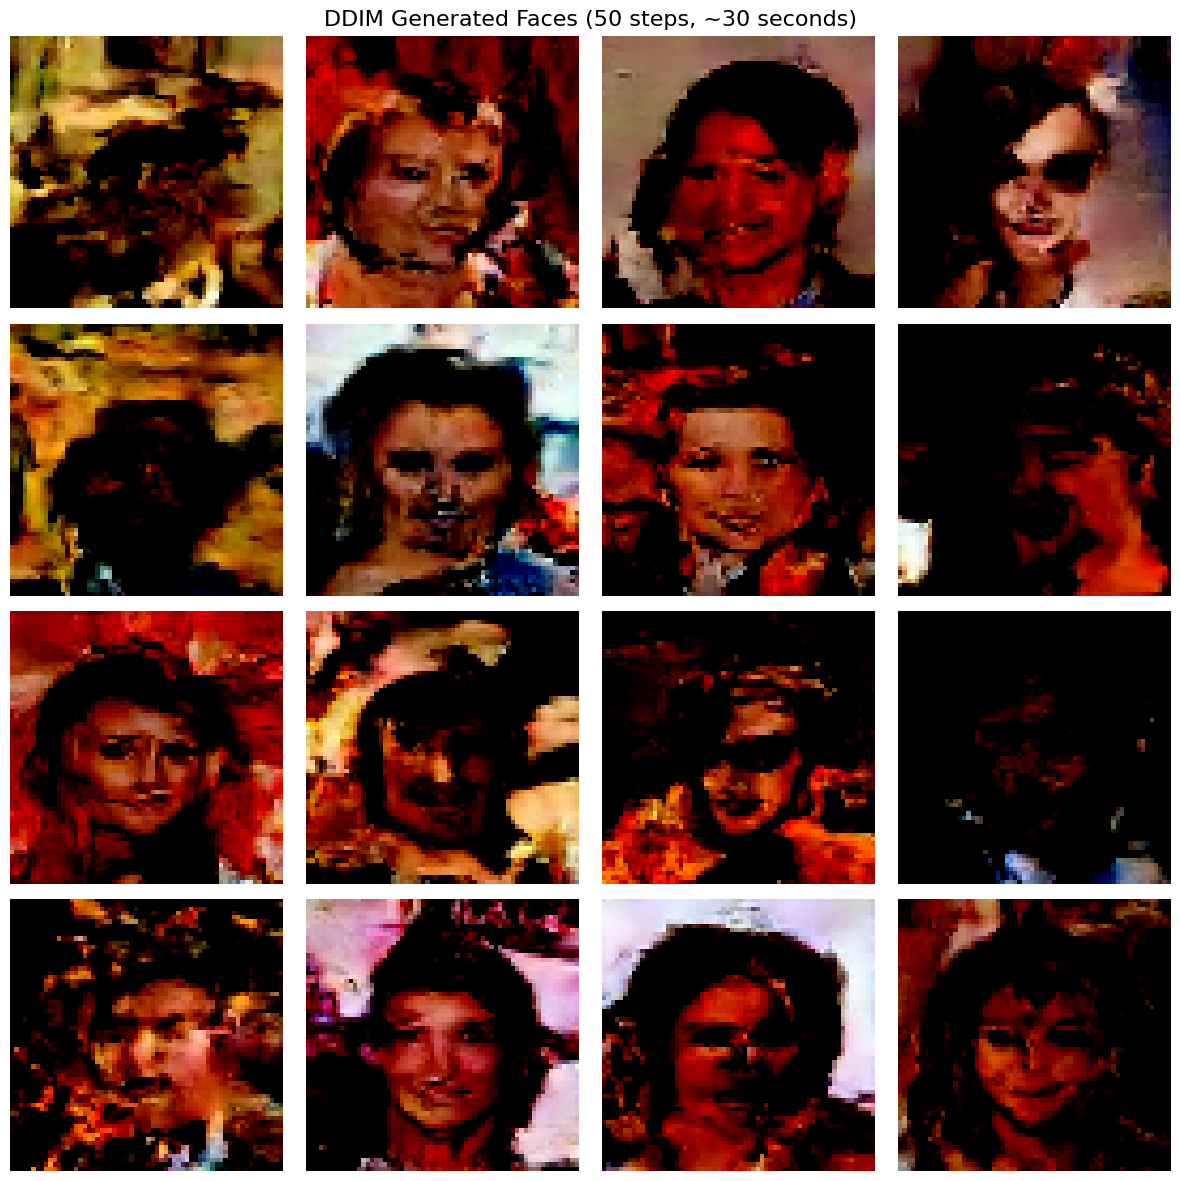


METHOD 2: Denoising Visualization (DDIM)
🎬 Visualizing denoising process...
Step 50/50 (t=0)))
 Denoising visualization complete!


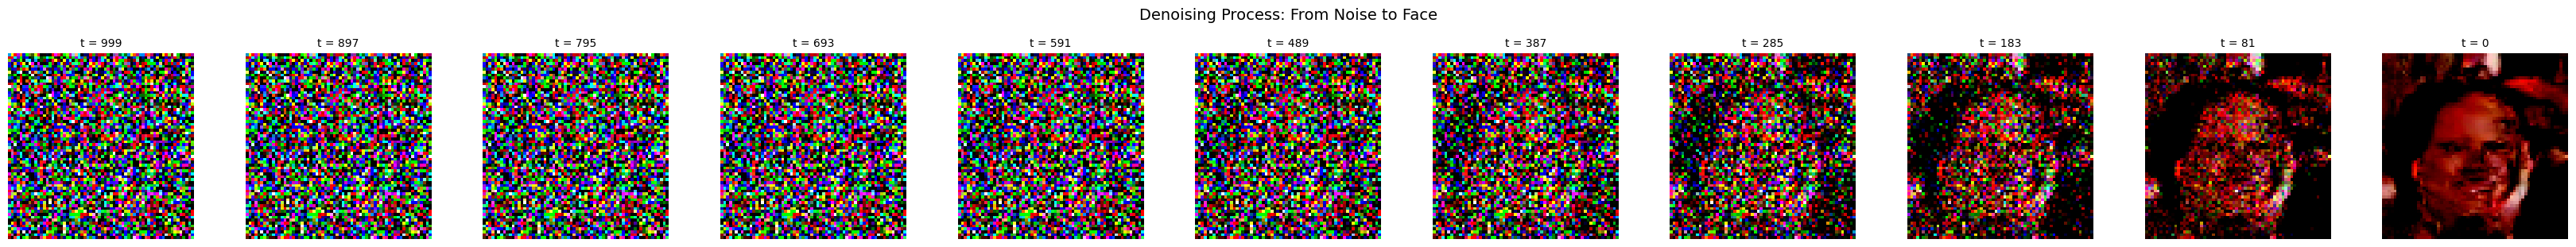


METHOD 3: Full DDPM Sampling (SLOW but highest quality)

METHOD 4: Quality Comparison (DDIM vs DDPM)
Generating 4 images with DDIM (10 steps)...
Step 10/10 (t=0))
 DDIM generation complete!
Generating 4 images with DDIM (25 steps)...
Step 25/25 (t=0)))
 DDIM generation complete!
Generating 4 images with DDIM (50 steps)...
Step 50/50 (t=0)))
 DDIM generation complete!


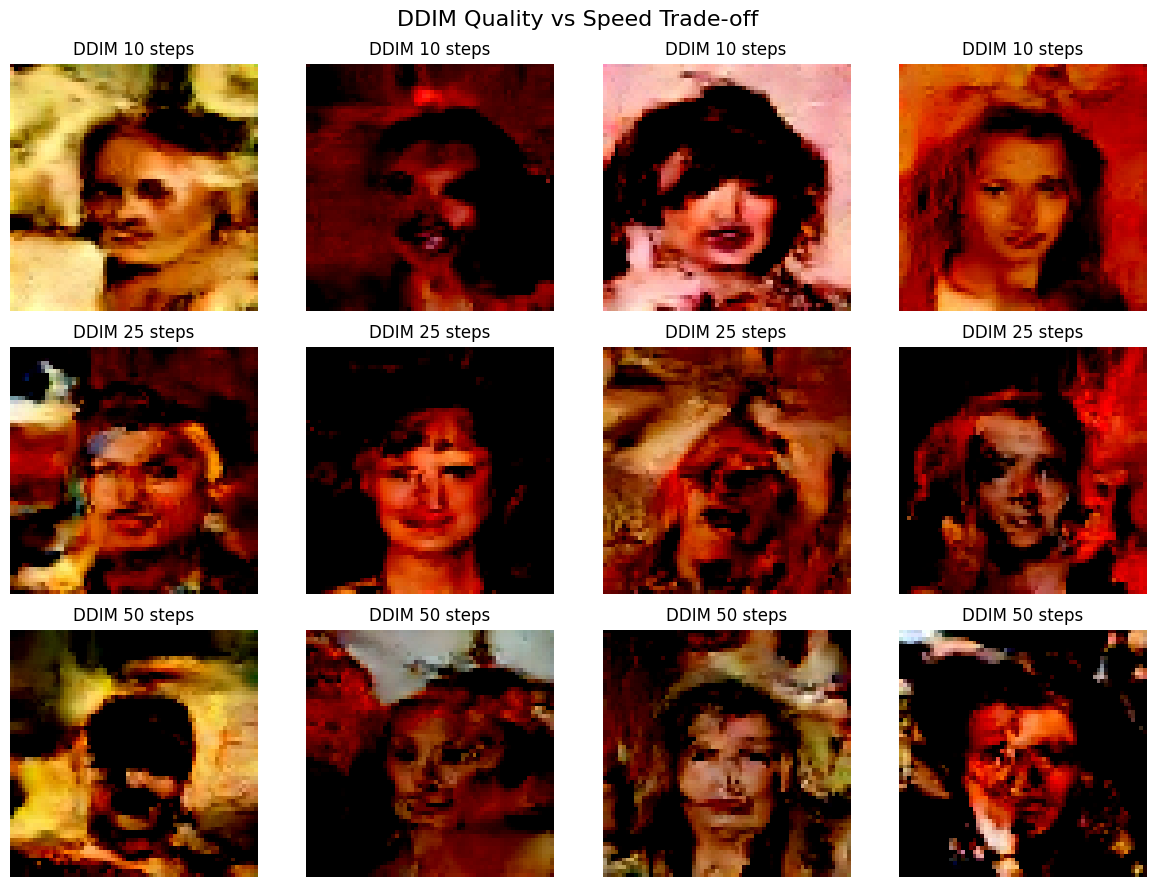


All visualizations complete!

Generated files:
  - ddim_generated_faces.png (16 faces, fast)
  - denoising_process.png (step-by-step visualization)
  - ddim_comparison.png (quality comparison)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def ddim_sample(model, num_images=16, num_steps=50, eta=0.0):
    """
    DDIM sampling - much faster than DDPM
    
    Args:
        model: Your trained U-Net model
        num_images: Number of images to generate
        num_steps: Number of denoising steps (50 is usually enough, vs 1000 in DDPM)
        eta: Stochasticity parameter (0=deterministic, 1=same as DDPM)
    """
    print(f"Generating {num_images} images with DDIM ({num_steps} steps)...")
    
    img = tf.random.normal((num_images, IM_SHAPE[0], IM_SHAPE[1], IM_SHAPE[2]))
    
    timesteps = np.linspace(0, TIME_STEPS - 1, num_steps, dtype=int)[::-1]
    
    for i, t in enumerate(timesteps):
        print(f"Step {i+1}/{num_steps} (t={t})", end='\r')
        
        t_tensor = tf.fill((num_images,), t)
        
        predicted_noise = model([img, t_tensor], training=False)
        
        alpha_t = alphas_cumprod[t]
        
        if i < len(timesteps) - 1:
            t_prev = timesteps[i + 1]
            alpha_t_prev = alphas_cumprod[t_prev]
        else:
            alpha_t_prev = tf.constant(1.0)
        
        pred_x0 = (img - tf.sqrt(1 - alpha_t) * predicted_noise) / tf.sqrt(alpha_t)
        pred_x0 = tf.clip_by_value(pred_x0, -1, 1)
        
        dir_xt = tf.sqrt(1 - alpha_t_prev - eta**2 * (1 - alpha_t_prev) / (1 - alpha_t) * (1 - alpha_t / alpha_t_prev)) * predicted_noise
        
        img = tf.sqrt(alpha_t_prev) * pred_x0 + dir_xt
        
        if eta > 0 and i < len(timesteps) - 1:
            noise = tf.random.normal(img.shape)
            sigma_t = eta * tf.sqrt((1 - alpha_t_prev) / (1 - alpha_t)) * tf.sqrt(1 - alpha_t / alpha_t_prev)
            img = img + sigma_t * noise
    
    print(f"\n DDIM generation complete!")
    
    img = tf.clip_by_value(img, 0, 1)
    return img.numpy()


#denoising visualization
def visualize_denoising_process(model, num_steps=50, save_every=5):
    """
    Generate ONE image and save intermediate steps to visualize denoising
    
    Args:
        model: Your trained U-Net model
        num_steps: Number of DDIM steps
        save_every: Save image every N steps
    """
    print(f"🎬 Visualizing denoising process...")
    
    img = tf.random.normal((1, IM_SHAPE[0], IM_SHAPE[1], IM_SHAPE[2]))
    
    saved_images = []
    saved_timesteps = []
    
    timesteps = np.linspace(0, TIME_STEPS - 1, num_steps, dtype=int)[::-1]
    
    for i, t in enumerate(timesteps):
        print(f"Step {i+1}/{num_steps} (t={t})", end='\r')
        
        if i % save_every == 0 or i == len(timesteps) - 1:
            saved_images.append(tf.clip_by_value(img[0], 0, 1).numpy())
            saved_timesteps.append(t)
        
        t_tensor = tf.fill((1,), t)
        predicted_noise = model([img, t_tensor], training=False)
        
        alpha_t = alphas_cumprod[t]
        
        if i < len(timesteps) - 1:
            t_prev = timesteps[i + 1]
            alpha_t_prev = alphas_cumprod[t_prev]
        else:
            alpha_t_prev = tf.constant(1.0)
        
        pred_x0 = (img - tf.sqrt(1 - alpha_t) * predicted_noise) / tf.sqrt(alpha_t)
        pred_x0 = tf.clip_by_value(pred_x0, -1, 1)
        
        dir_xt = tf.sqrt(1 - alpha_t_prev) * predicted_noise
        img = tf.sqrt(alpha_t_prev) * pred_x0 + dir_xt
    
    print(f"\n Denoising visualization complete!")
    
    num_images = len(saved_images)
    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))
    
    if num_images == 1:
        axes = [axes]
    
    for i, (img_data, t) in enumerate(zip(saved_images, saved_timesteps)):
        axes[i].imshow(img_data)
        axes[i].set_title(f't = {t}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Denoising Process: From Noise to Face', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('denoising_process.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    return saved_images, saved_timesteps


def ddpm_sample_with_visualization(model, num_images=1, save_at=[999, 800, 600, 400, 200, 100, 50, 0]):
    """
    Full DDPM sampling (1000 steps) with visualization at specific timesteps
    
    Args:
        model: Your trained U-Net model
        num_images: Number of images to generate
        save_at: List of timesteps to save for visualization
    """
    print(f" Full DDPM sampling (1000 steps) - This will be slow...")
    
    img = tf.random.normal((num_images, IM_SHAPE[0], IM_SHAPE[1], IM_SHAPE[2]))
    
    saved_images = {}
    
    for t in reversed(range(TIME_STEPS)):
        if t % 100 == 0:
            print(f"⏳ Timestep: {t}/{TIME_STEPS}", end='\r')
        
        # Save at specific timesteps
        if t in save_at:
            saved_images[t] = tf.clip_by_value(img[0], 0, 1).numpy()
        
        # DDPM sampling step
        t_tensor = tf.fill((num_images,), t)
        img = p_sample(model, img, t_tensor, t)
    
    print(f"\n DDPM generation complete!")
    
    # Plot progression
    fig, axes = plt.subplots(1, len(save_at), figsize=(3 * len(save_at), 3))
    
    for i, t in enumerate(save_at):
        if t in saved_images:
            axes[i].imshow(saved_images[t])
            axes[i].set_title(f't = {t}', fontsize=10)
            axes[i].axis('off')
    
    plt.suptitle('Full DDPM Denoising Process (1000 steps)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('ddpm_denoising_full.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    return saved_images


# FAST GENERATION WITH DDIM (20x faster!)
print("\n" + "="*60)
print("METHOD 1: DDIM Sampling (FAST)")
print("="*60)
fast_images = ddim_sample(model, num_images=16, num_steps=50, eta=0.0)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(fast_images[i])
    ax.axis('off')
plt.suptitle('DDIM Generated Faces (50 steps, ~30 seconds)', fontsize=16)
plt.tight_layout()
plt.savefig('ddim_generated_faces.png', dpi=150, bbox_inches='tight')
plt.show()


# VISUALIZE DENOISING PROCESS WITH DDIM
print("\n" + "="*60)
print("METHOD 2: Denoising Visualization (DDIM)")
print("="*60)
denoising_images, timesteps = visualize_denoising_process(model, num_steps=50, save_every=5)


# FULL DDPM WITH VISUALIZATION (slower but higher quality)
print("\n" + "="*60)
print("METHOD 3: Full DDPM Sampling (SLOW but highest quality)")
print("="*60)
# Uncomment below if you want to try full DDPM (takes ~5-10 minutes per image)
# ddpm_images = ddpm_sample_with_visualization(model, num_images=1, save_at=[999, 750, 500, 250, 100, 0])


# COMPARISON: Generate same image with different methods
print("\n" + "="*60)
print("METHOD 4: Quality Comparison (DDIM vs DDPM)")
print("="*60)
tf.random.set_seed(42)
np.random.seed(42)

# DDIM with different steps
ddim_10 = ddim_sample(model, num_images=4, num_steps=10, eta=0.0)
ddim_25 = ddim_sample(model, num_images=4, num_steps=25, eta=0.0)
ddim_50 = ddim_sample(model, num_images=4, num_steps=50, eta=0.0)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):
    axes[0, i].imshow(ddim_10[i])
    axes[0, i].set_title(f'DDIM 10 steps')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(ddim_25[i])
    axes[1, i].set_title(f'DDIM 25 steps')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(ddim_50[i])
    axes[2, i].set_title(f'DDIM 50 steps')
    axes[2, i].axis('off')

plt.suptitle('DDIM Quality vs Speed Trade-off', fontsize=16)
plt.tight_layout()
plt.savefig('ddim_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAll visualizations complete!")
print("\nGenerated files:")
print("  - ddim_generated_faces.png (16 faces, fast)")
print("  - denoising_process.png (step-by-step visualization)")
print("  - ddim_comparison.png (quality comparison)")